In [48]:
#imports
import sys
import subprocess 
import scipy.constants as con
import scipy.optimize as opt
import importlib
#import scipy as sp
import numpy as np
from scipy import special
from scipy import integrate
from scipy.optimize import root_scalar
from scipy.integrate._ivp import common as jacpack

import matplotlib.pyplot as plt

import pynucastro as pyna
reaclibrary = pyna.ReacLibLibrary()

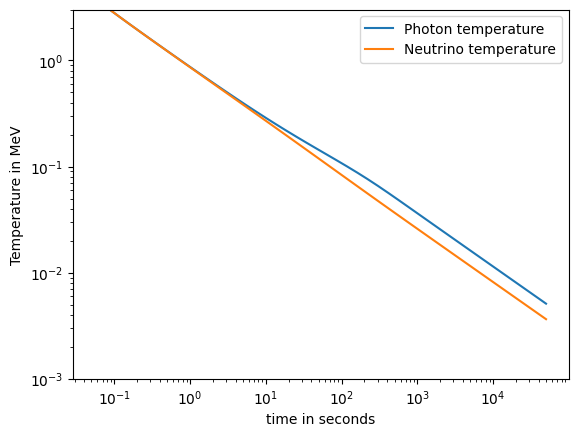

In [49]:
#Background
#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z


timeunit =1.519*10**21  #MeV/hbar in unit of 1/second 

n_life=879.6*timeunit   #Neutron lifetime in units of MeV/hbar
Q=1.293                 #neutron proton mass difference in MeV
M_u=931.494102          #atomic mass unit in MeV
SBC=np.pi**2/60         #Stefan-Boltzmann constant in natural units
G=6.709e-45             #gravatational constant in units of c=hbar=MeV=1
#infapprox=1e3           #large number acting as upper limit on itegrals
n_nu=3.046              #number of neutrino families with correction from 
                        #Nollett and Steigman, BBN and the CMB constrain neutrino coupled light WIMPs, 2015

TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K
cm3s=1.167*10**-11  #conversion factor for cm^3/s
gcm3=232012         #conversion factor for g/cm^3
meter=5.068e12      #conversion factor for m
cm=5.068e10         #conversion factor for cm
barn=389.4          #conversion factor for barn
T_ini=3.8#27/TMeV2T9    #initial temperature in MeV
e_mass=0.51099895   #electron mass in MeV
z_ini=e_mass/T_ini

def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1))))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)*(z*x*np.exp(z*x))/(T*(np.exp(z*x)+1)**2)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,10)])


def P_e(T): #electron/positron pressure
    z=e_mass/T
    '''
    func=lambda x: 2/(3*np.pi**2)*e_mass**4*((x**4*(x**2+1)**-0.5)/((np.exp(z*(x**2+1)**0.5)+1)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    #Fowler and Hoyle 1964
    #return 4/np.pi**2*T**4*np.sum([(-1)**(n+1)/n**4*special.kn(2,n*z) for n in range(1,10)])
    
    #Kawano
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,10)])  



def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3



### Initial conditions ###

n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701*T_ini) #initial number density of photons based mean photon energy

eta=6.1e-10     #CMB baryon-to-photon ratio
eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse


rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density

h_ini=M_u/T_ini**3*eta_ini*n_gamma_ini  #initial h

t_ini=1.226*10**21/T_ini**2 #initial time in hbar/MeV

rho_b_ini=M_u*eta_ini*n_gamma_ini    #initial baryon density

rho_tot_ini=rho_e(T_ini)+rho_gamma(T_ini)+rho_nu_ini#+rho_b_ini  #initial total energy density

H_ini=np.sqrt(8*np.pi/3*G*rho_tot_ini)


def rho_nu(T,a): #neutrina energy density
    #return 7/8*np.pi**2/15*T**4
    return rho_nu_ini/a**4

def rho_b(a):
    return rho_b_ini/a**3



#def P_b(T,h):
#    return h*T**4*2/3*

#Phie_ini=np.pi**2/2*con.Avogadro*h_ini/z_ini**3*1/sum([(-1)**(n+1)*n*L(n*z_ini) for n in range(1,20)]) 




### Solving the background ###

def rho_tot(T,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(T,a)#+rho_b(a)

def rho_set(T,a): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)#+rho_b(a)

def H(T,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,a))

#Derivative from Kavano D.18
def dTdt(t,T,a):
    return -3*H(T,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))

#Derivative from Kavano D.19
def dhdt(t,T,h,a):
    return -3*h*(H(T,h,a)+dTdt(t,T,h,a)/T)

#Derivative from how H is defined
def dadt(t,T,a):
    return a*H(T,a)


#Derivatives for Jacobian

def dadT(T,a):
    return -((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))*a/3

def drho_nu(T,a): #neutrina energy density
    return -rho_nu_ini*4/a**5

def drho_b(T,a):
    return -h_ini*T_ini**3*3/a**4

def rho_totdT(T,a): #total density
    return drho_e(T)+drho_gamma(T)+(drho_nu(T,a))#+drho_b(T,a))*dadT(T,a)

def rho_totda(T,a): #total density
    return (drho_e(T)+drho_gamma(T))/dadT(T,a)+drho_nu(T,a)#+drho_b(T,a)



def HdT(T,a):   #Hubble parameter deriv with respect to Temperature
    return 4*np.pi/3*G*rho_totda(T,a)/H(T,a)

def Hda(T,a):   #Hubble parameter deriv with respect to Scale factor
    return 4*np.pi/3*G*rho_totdT(T,a)/H(T,a)

def dadtda(t,T,a):
    return H(T,a)+a*Hda(T,a)


def dadtdT(t,T,a):
    return dadT(T,a)*H(T,a)+a*HdT(T,a)



t_range=[t_ini,5e4*timeunit]            #time range for integration
#t_space=np.linspace(*t_range,1000)      #time range for approximate temperature

#combining derivatives
def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = a
    return [dTdt(t,*y),dadt(t,*y)]



# Solving it
sol = integrate.solve_ivp(dbackground, t_range, [T_ini,1],method='Radau')#,t_eval=t_space)

plt.figure()
# Plot the Temperature
plt.plot(sol.t/timeunit, sol.y[0], label='Photon temperature')

# Test with completely radiation dominated universe
t_space=sol.t
T_approx=np.sqrt(1.226*10**21/t_space)
#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(t_space/timeunit, T_ini/sol.y[1], label='Neutrino temperature')


#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()

#plt.figure


n_bparams=2


In [50]:
import bbn_test_integrate as bbn_n
importlib.reload(bbn_n)
#import He4_test_integrate as He4_n
bbn_n.nnuc

10

In [51]:
#compile rhs and Jacobian
bbn_n.rhs(1000, np.ones(bbn_n.nnuc),0.00001, 1e7)
bbn_n.jacobian(1000, np.ones(bbn_n.nnuc),0.00001, 1e7)
print('done')

done


In [52]:
#                 a  b  c  d  e  f
A = np.array([[0, 1, 2, 3, 4, 5],
                 [1, 0, 3, 4, 5, 6],
                 [2, 3, 0, 5, 6, 7],
                 [3, 4, 5, 0, 7, 8],
                 [4, 5, 6, 7, 0, 9],
                 [5, 6, 7, 8, 9, 0]])

#            a  d  b  e  c  f
new_order = [0, 3, 1, 4, 2, 5]
A1 = A[:, new_order][new_order]

In [53]:
A1

array([[0, 3, 1, 4, 2, 5],
       [3, 0, 4, 7, 5, 8],
       [1, 4, 0, 5, 3, 6],
       [4, 7, 5, 0, 6, 9],
       [2, 5, 3, 6, 0, 7],
       [5, 8, 6, 9, 7, 0]])

In [54]:
#Setup isotopes based on Alterbbn
Y_labels=['n','p','H2','H3','He3','He4','Li6','Li7','Li8','Be7','Be9','B8','B10','B11','B12','C11','C12','C13','C14','N12','N13','N14','N15','O14','O15','O16']
Alter_Yl=["n","p","H2","H3","He3","He4","Li6","Li7","Be7","Li8","B8","Be9","B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]
A=np.array([1,1,2,3,3,4,6,7,8,7,9,8,10,11,12,11,12,13,14,12,13,14,15,14,15,16])
Z=sorted([0,1,1,1,2,2,3,3,4,3,5,4,5,5,6,5,6,7,6,7,6,7,8,7,8,8.])
Alter_A=[1.,1.,2.,3.,3.,4.,6.,7.,7.,8.,8.,9.,10.,11.,11.,12.,12.,12.,13.,13.,14.,14.,14.,15.,15.,16.]
Alter_Z=[0.,1.,1.,1.,2.,2.,3.,3.,4.,3.,5.,4.,5.,5.,6.,5.,6.,7.,6.,7.,6.,7.,8.,7.,8.,8.]
print()

def Altersort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])])
#print([label for _, label in sorted(zip(A, Y_labels))])

def PNAsort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])])    


print(Alter_Yl)
print(Altersort(Y_labels))

print(Y_labels)
print(PNAsort(Alter_Yl))


['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Be7', 'Li8', 'B8', 'Be9', 'B10', 'B11', 'C11', 'B12', 'C12', 'N12', 'C13', 'N13', 'C14', 'N14', 'O14', 'N15', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Be7', 'Li8', 'B8', 'Be9', 'B10', 'B11', 'C11', 'B12', 'C12', 'N12', 'C13', 'N13', 'C14', 'N14', 'O14', 'N15', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Li8', 'Be7', 'Be9', 'B8', 'B10', 'B11', 'B12', 'C11', 'C12', 'C13', 'C14', 'N12', 'N13', 'N14', 'N15', 'O14', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Li8', 'Be7', 'Be9', 'B8', 'B10', 'B11', 'B12', 'C11', 'C12', 'C13', 'C14', 'N12', 'N13', 'N14', 'N15', 'O14', 'O15', 'O16']


In [55]:
#Initial conditions for Y
#mass of various nuclei converted to MeV
m_n  =  1.0086649159  *M_u
m_p  =  1.00782503190 *M_u
m_d  =  2.01410177784 *M_u
m_t  =  3.01604928132 *M_u
m_He3 = 3.01602932197 *M_u
m_He4 = 4.00260325413 *M_u
m_Li6 = 6.0151228874  *M_u
m_Li7 = 7.016003434   *M_u

m_Be7 = 7.01692871    *M_u

nNucs=bbn_n.nnuc

Alter_Yl=["n","p","H2","H3","He3","He4","Li6","Li7","Be7","Li8","B8","Be9","B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]
Alter_A=[1.,1.,2.,3.,3.,4.,6.,7.,7.,8.,8.,9.,10.,11.,11.,12.,12.,12.,13.,13.,14.,14.,14.,15.,15.,16.]
Alterspin=[0.5,0.5,1.,0.5,0.5,0.,1.,1.5,1.5,2.,2.,1.5,3.,1.5,1.5,1.,0.,1.,0.5,0.5,0.,1.,0.,0.5,0.5,0.]
Alter_mass_excess=[8.071388,7.289028,13.135825,14.949915,14.931325,2.424931,14.0864,14.9078,15.7696,20.9464,22.9212,11.34758,12.05086,8.6680,10.6506,13.3690,0.,17.3382,3.125036,5.3455,3.019916,2.863440,8.006521,0.101439,2.8554,-4.737036]
Alter_mass=[Alter_A[i]*M_u+Alter_mass_excess[i] for i in range(nNucs)]

spin=PNAsort(Alterspin)[0:nNucs]
Y_labels=['n','p','H2','H3','He3','He4','Li6','Li7','Li8','Be7','Be9','B8','B10','B11','B12','C11','C12','C13','C14','N12','N13','N14','N15','O14','O15','O16']
A=np.array(PNAsort(Alter_A))[0:nNucs]


m_Nucs = np.array(PNAsort(Alter_mass))

def rho_bY_cgs(y):
    return sum(m_Nucs*y[n_bparams:])*eta_ini*n_gamma_ini/y[1]**3*gcm3

#equilibrium ratios for simple rates #Pebbles
def G_np(T,a):

    N=eta_ini*n_gamma_ini/a**3 #number density
    return 4/3*(m_n*m_p*T/(2*np.pi*m_d))**1.5/N*np.exp((m_d-m_n-m_p)/T)

def G_nHe3(T):
    return 9/4*(m_d**2/(m_He3*m_n))**1.5*np.exp((m_n+m_He3-2*m_d)/T)

def G_tp(T):
    return 9/4*(m_d**2/(m_t*m_p))**1.5*np.exp((m_p+m_t-2*m_d)/T)  

def G_tp_nHe3(T):
    return ((m_He3*m_n)/(m_t*m_p))**1.5*np.exp((m_p+m_t-(m_n+m_He3))/T)

def G_nHe4(T):
    return 3*((m_d+m_t)/(m_He4*m_n))**1.5*np.exp((m_He4+m_n-m_d-m_t)/T)  

#Initial conditions

Y_ini=np.zeros(nNucs)+1e-80
#Y_ini=np.array([1e-20 for i in range(nNucs)])

Xn_ini = 1/(np.exp(Q/T_ini)+1)

#Initial condition based on thermal equilibrium amongst in the most important reactions

Y_ini[0] = Xn_ini        #Set initial neutron mass fraction
Y_ini[1] = 1 - Xn_ini    #Set initial proton mass fraction
Y_ini[2] = Y_ini[0]*Y_ini[1]/G_np(T_ini,1)          #Set initial deuterium mass fraction
Y_ini[3] = Y_ini[2]**2/Y_ini[1]/G_tp(T_ini)
Y_ini[4] = Y_ini[2]**2/Y_ini[0]/G_nHe3(T_ini)
Y_ini[5] = Y_ini[2]*Y_ini[3]/Y_ini[0]/G_nHe4(T_ini)


Y_ini[6] = 1e-55
Y_ini[7] = 1e-66
Y_ini[8] = 1e-77
Y_ini[9] = 1e-66

dYdt_ini=lambda Y : bbn_n.rhs(t_ini/timeunit, Y ,rho_bY_cgs([T_ini,1]+list(Y)), T_ini*TMeV2T9*1e9)

'''
Y_ini[10] = 1e-88#1.78715138e-88
Y_ini[11] = 1e-77


bbn_n.rhs(t_ini/timeunit, Y_ini,rho_bY_cgs([T_ini,1]+list(Y_ini)), T_ini*TMeV2T9*1e9)





print(Y_ini)
print(dYdt_ini(Y_ini)/Y_ini)

delta=1e-89
sign=dYdt_ini(Y_ini)[10]>0

#while abs(dYdt_ini(Y_ini)[10]/Y_ini[10])>dYdt_ini(Y_ini)[7]/Y_ini[7]:
for i in range(110):
    print(dYdt_ini(Y_ini)[10])
    if dYdt_ini(Y_ini)[10]>0:
        Y_ini[10]+=delta
        
    else: 
        Y_ini[10]-=delta
        if sign: delta*=0.2

    #print(Y_ini[10])


print(delta)
print(Y_ini)
print(dYdt_ini(Y_ini)/Y_ini)

'''

'\nY_ini[10] = 1e-88#1.78715138e-88\nY_ini[11] = 1e-77\n\n\nbbn_n.rhs(t_ini/timeunit, Y_ini,rho_bY_cgs([T_ini,1]+list(Y_ini)), T_ini*TMeV2T9*1e9)\n\n\n\n\n\nprint(Y_ini)\nprint(dYdt_ini(Y_ini)/Y_ini)\n\ndelta=1e-89\nsign=dYdt_ini(Y_ini)[10]>0\n\n#while abs(dYdt_ini(Y_ini)[10]/Y_ini[10])>dYdt_ini(Y_ini)[7]/Y_ini[7]:\nfor i in range(110):\n    print(dYdt_ini(Y_ini)[10])\n    if dYdt_ini(Y_ini)[10]>0:\n        Y_ini[10]+=delta\n        \n    else: \n        Y_ini[10]-=delta\n        if sign: delta*=0.2\n\n    #print(Y_ini[10])\n\n\nprint(delta)\nprint(Y_ini)\nprint(dYdt_ini(Y_ini)/Y_ini)\n\n'

In [56]:
#Initial conditions

import scipy.special
def get_Y_ini(Xn_ini):
    Y_ini2 = np.zeros(nNucs)+1e-50
    #Y_ini=np.array([1e-20 for i in range(nNucs)])


    #Xn_ini = 1/(np.exp(Q/T_ini)+1)
    

    B=[(m_Nucs[1]*Z[i]+m_Nucs[0]*(A[i]-Z[i]))-m_Nucs[i] for i in range(nNucs)]
    g = 1+2*np.array(spin)
        
    for iter1 in range(30):
        Xp_ini = np.exp(Q/T_ini)*Xn_ini
        Y_ini2[0] = Xn_ini        #Set initial neutron mass fraction
        Y_ini2[1] = Xp_ini
        #Set initial proton mass fraction
        X_sum = Y_ini2[0] + Y_ini2[1]
        for i in range(2,nNucs):
            tmp = scipy.special.zeta(3)**(A[i] - 1)*np.pi**((1 - A[i])/2)*2**((3*A[i] - 5)/2)*A[i]**(5/2)
            #print(f'A({key}) = {A} : {g[key]*tmp}')
            Y_ini2[i] = g[i]*tmp*(T_ini/m_n)**(3*(A[i] - 1)/2)*eta_ini**(A[i] - 1)*Xp_ini**Z[i]*Xn_ini**(A[i] - Z[i])*np.exp(B[i]/T_ini)/A[i]
            X_sum += Y_ini2[i]*A[i]
        #print(X_sum)
        Xn_ini += (1 - X_sum)/nNucs
        
    return Y_ini2
Xn_ini = 1/(np.exp(Q/T_ini)+1)
Y_ini2 = get_Y_ini(Xn_ini)

    #B12 = 92.2 

#Initial condition based on thermal equilibrium amongst in the most important reactions
B2 = 2.22452
B3 = 7.72
B4 = 28.295673


print(f'From initial guess:')
print('\t'.join([f'{yy:.2e}' for yy in Y_ini]))
print('\t'.join([f'{yy:.2e}' for yy in dYdt_ini(Y_ini)]))
print(f'From equilibrium conditions:')
print('\t'.join([f'{yy:.2e}' for yy in Y_ini2]))
print('\t'.join([f'{yy:.2e}' for yy in dYdt_ini(Y_ini2)]))


From initial guess:
4.16e-01	5.84e-01	1.53e-12	3.33e-24	3.83e-24	8.54e-30	1.00e-55	1.00e-66	1.00e-77	1.00e-66


-2.84e+15	-2.84e+15	2.84e+15	6.56e+03	-1.61e-08	-3.28e+03	3.42e-35	4.60e-40	-5.47e-59	1.39e-39
From equilibrium conditions:
4.16e-01	5.84e-01	1.53e-12	3.34e-24	3.84e-24	2.28e-34	5.53e-58	2.15e-69	1.93e-81	1.96e-69
-2.70e+15	-2.70e+15	2.70e+15	3.68e-03	1.70e-09	-1.84e-03	4.30e-42	2.61e-46	2.47e-64	7.86e-46


In [57]:
AdYdt_ini=lambda Y : Altersort(bbn_n.rhs(t_ini/timeunit, PNAsort(Y) ,rho_bY_cgs([T_ini,1]+list(PNAsort(Y))), T_ini*TMeV2T9*1e9))
AdYdt_jac=lambda Y : bbn_n.jacobian(t_ini/timeunit, PNAsort(Y) ,rho_bY_cgs([T_ini,1]+list(PNAsort(Y))), T_ini*TMeV2T9*1e9)[:, Altersort(range(nNucs))][Altersort(range(nNucs))]
import scipy.linalg as la
aY_ini=Altersort(Y_ini2)
def solve_using_svd(U, s, Vh, b):
    bb = U.T @ b
    y = bb/s
    x = Vh.T @ y
    return x
Yj = np.array([YY for YY in aY_ini])
cut_start = 0
for cut in range(cut_start, len(Yj) - 2, 1):
    for j in range(10):
        print(cut, j)
        print(Yj)
        fyj = -AdYdt_ini(Yj)
        jac = AdYdt_jac(Yj)
        if np.any(np.isnan(Yj)) or np.any(np.isinf(Yj)):
            print('Yj:', Yj)
            raise ValueError
        if np.any(np.isnan(fyj)) or np.any(np.isinf(fyj)):
            print('Yj:', Yj)
            print('fyj:', fyj)
            raise ValueError
        # Implement cut:
        fyj = fyj[cut:]
        jac = jac[cut:, cut:]
        
        # Solution using SVD
        U, s, Vh = la.svd(jac)    
        x = solve_using_svd(U, s, Vh, fyj)
        for k in range(1):
            #A · δx = A · (x + δx) − b
            residuals = jac @ x - fyj
            dx = solve_using_svd(U, s, Vh, residuals)
            x -= dx
        Yj[cut:] += x


def print_stuff(YY, name=''):
    print(f'From {name}:')
    print('\t'.join([f'{yy:.2e}' for yy in YY]))
    print('\t'.join([f'{yy:.2e}' for yy in AdYdt_ini(YY)]))
print_stuff(aY_ini, 'equilibrium conditions')
print_stuff(Yj, 'manual tuning')

0 0
[4.15745554e-01 5.84254446e-01 1.52976503e-12 3.34154192e-24
 3.84088729e-24 2.28426251e-34 5.53106287e-58 2.15226948e-69
 1.96229034e-69 1.92868031e-81]
0 1
[ 4.13475267e-01  5.84254446e-01  1.55387648e-12  5.47468178e-18
  6.21302981e-18  7.32790957e-28  4.65445530e-21  3.12614443e-26
 -4.19770361e-27  1.89432008e-20]
0 2
[ 4.13658951e-01  5.84254446e-01  1.55103575e-12 -2.45853820e-18
 -2.82641759e-18 -1.15465232e-21 -1.08368097e-21 -6.85504213e-28
  8.54373110e-29 -2.96757654e-22]
0 3
[ 4.15309761e-01  5.84254446e-01  1.55751238e-12 -5.21226589e-21
  6.64901488e-21 -1.12808372e-22 -1.49092924e-21 -1.14445160e-27
  1.38733047e-28 -5.34942015e-22]
0 4
[ 4.20781176e-01  5.84254446e-01  1.58064327e-12  1.50424424e-18
  1.70562675e-18  2.65692443e-24 -1.63545273e-21  1.06660483e-26
 -1.46601558e-27  6.85117065e-21]
0 5
[ 4.15455038e-01  5.84254446e-01  1.56918266e-12  6.96771369e-19
  8.15377689e-19 -3.17233996e-24 -1.35415296e-20 -6.35484187e-27
  7.19029461e-28 -2.33034954e-21]
0 

In [58]:
'''
#finding rates that contribute to Berylium9 production
all_nuclei = Y_labels[:nNucs]#["p","n", "h2", "h3", "he3", "he4","Li6","Li7","Be7","Li8","B8","Be9"]#,"B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]
bbn_library = reaclibrary.linking_nuclei(all_nuclei)
bbn_network = pyna.networks.PythonNetwork(libraries=bbn_library)


filter = pyna.RateFilter(products=["Be9"], exact=False)
Be9rates = bbn_library.filter(filter).get_rates()
reversefilter = pyna.RateFilter(reactants=["Be9"], exact=False)
Be9reverserates = bbn_library.filter(reversefilter).get_rates()
print(Be9rates)
print(Be9reverserates)
'''

[Li6 + He4 ⟶ p + Be9, Li7 + H3 ⟶ n + Be9, Li8 + H2 ⟶ n + Be9, n + He4 + He4 ⟶ Be9 + 𝛾, H2 + He4 + He4 ⟶ p + Be9, n + p + He4 + He4 ⟶ p + Be9]
[Be9 ⟶ n + He4 + He4, Be9 + n ⟶ H2 + Li8, Be9 + n ⟶ H3 + Li7, Be9 + p ⟶ He4 + Li6, Be9 + p ⟶ H2 + He4 + He4, Be9 + p ⟶ n + p + He4 + He4]


In [66]:
#finding rates that contribute to proton production
all_nuclei = Y_labels[:nNucs]#["p","n", "h2", "h3", "he3", "he4","Li6","Li7","Be7","Li8"]#,"B8","Be9","B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]
bbn_library = reaclibrary.linking_nuclei(all_nuclei)
bbn_network = pyna.networks.PythonNetwork(libraries=bbn_library)


filter = pyna.RateFilter(products=["p"], exact=False)
prates = bbn_library.filter(filter).get_rates()
reversefilter = pyna.RateFilter(reactants=["p"], exact=False)
preverserates = bbn_library.filter(reversefilter).get_rates()
print(prates)
print(preverserates)

[n ⟶ p + e⁻ + 𝜈, H2 ⟶ n + p, He3 ⟶ p + H2, He4 ⟶ p + H3, Be7 ⟶ p + Li6, Li6 ⟶ n + p + He4, H2 + H2 ⟶ p + H3, He3 + n ⟶ p + H3, He3 + H2 ⟶ p + He4, He3 + He4 ⟶ p + Li6, He4 + He4 ⟶ p + Li7, Li6 + H2 ⟶ p + Li7, Li7 + H2 ⟶ p + Li8, Be7 + n ⟶ p + Li7, H2 + p ⟶ n + p + p, He3 + H3 ⟶ n + p + He4, He3 + He3 ⟶ p + p + He4, Be7 + H2 ⟶ p + He4 + He4, Li7 + He3 ⟶ n + p + He4 + He4, Be7 + H3 ⟶ n + p + He4 + He4, Be7 + He3 ⟶ p + p + He4 + He4, n + p + p ⟶ p + H2, n + He4 + He4 ⟶ p + Li8]
[n + p ⟶ H2 + 𝛾, p + p ⟶ H2 + e⁺ + 𝜈, p + p + e⁻ ⟶ H2 + 𝜈, H2 + p ⟶ He3 + 𝛾, H3 + p ⟶ He4 + 𝛾, He3 + p ⟶ He4 + e⁺ + 𝜈, Li6 + p ⟶ Be7 + 𝛾, H3 + p ⟶ n + He3, H3 + p ⟶ H2 + H2, p + He4 ⟶ H2 + He3, Li6 + p ⟶ He4 + He3, Li7 + p ⟶ n + Be7, Li7 + p ⟶ H2 + Li6, Li7 + p ⟶ He4 + He4, Li8 + p ⟶ H2 + Li7, H2 + p ⟶ n + p + p, Li8 + p ⟶ n + He4 + He4, n + p + He4 ⟶ Li6 + 𝛾, n + p + p ⟶ p + H2, n + p + He4 ⟶ H3 + He3, p + p + He4 ⟶ He3 + He3, p + He4 + He4 ⟶ H2 + Be7, n + p + He4 + He4 ⟶ He3 + Li7, n + p + He4 + He4 ⟶ H3 + Be7, p

In [64]:
#Function for evaluating pyna rates at a initial conditions time
def ratevalue(rate):
    Tpeak=T_ini*TMeV2T9*1e9
    value=rate.eval(Tpeak)
    for reactant in rate.reactants:
        i=3+Y_labels.index(reactant.caps_name)
        value*=Y_ini2[i]
        

    return  value

In [65]:
#Finding values of Y_p derivatives at the first peak

#print(f'dlog(Y)/dt at {data[i_peak,0]/timeunit:.2f} seconds')
for rate in sorted(prates,key=lambda x: ratevalue(x),reverse=True):
    print(str(ratevalue(rate))+'\t'+rate.fname)
    #print(rate.eval(Tpeak))
    #print(rate.reactants)


IndexError: index 12 is out of bounds for axis 0 with size 10

In [61]:
#Combining background and network



        # enumeration for different isotopes
        #  0   1   2   3    4     5     6     7     8
'''
step=20
print(solY.t[step]/timeunit)
print(solY.y.T[step])
initial_param=solY.y.T[step]
t_range=[solY.t[step],5e4*timeunit]
'''
initial_param=[T_ini,1]+list(PNAsort(Yj))
t_range=[0,5e4*timeunit]

n_params=nNucs+n_bparams
sparcity=None#np.zeros((n_params,n_params))+1
#sparcity[:3,3:]=0
#sparcity[n_bparams:,:n_bparams]=0
def ndbackground(t,y):   #solve h and T, y[0] = T, y[1] = h and y[2] = a
    return [dTdt(t,*y),dadt(t,*y)]


#testdata=[]

def ndall(t,y):   #solve h and T, y[0] = T and y[1] = a   
    #print(ndbackground(t,y[:n_bparams])+list( bbn_n.rhs(t/timeunit, y[n_bparams:],eta_ini*n_gamma_ini/y[2]**3*m_p*gcm3, y[0]*TMeV2T9*1e9)/timeunit))
    result=ndbackground(t,y[:n_bparams])+list( bbn_n.rhs(t/timeunit, y[n_bparams:],rho_bY_cgs(y), y[0]*TMeV2T9*1e9)/timeunit)
    #testdata.append([t]+result)                 
    return result


In [62]:
#solving with analytic jacobian




def jacY_anal(t,y):
    return bbn_n.jacobian(t/timeunit, y[n_bparams:],rho_bY_cgs(y), y[0]*TMeV2T9*1e9)/timeunit

def jacfun(t,x):
    return np.array([ndall(t,row)  for row in x.T]).T

Factor=None
def jacobian(t,y):
    '''
    global Factor
    jac_rhs_value=np.array(ndall(t,y))
    jactest=jacpack.num_jac(jacfun,t,y,jac_rhs_value,1e-30,Factor)
    Factor=jactest[1]
    jactest[0][:,:] = np.zeros((n_params,n_params))
    jactest[0][2:,:] = np.zeros((nNucs,n_params))
    jactest[0][:,2:] = np.zeros((n_params,nNucs))
    jactest[0][2:,2:]=jacY_anal(t,y)
    
    
    return jactest[0]
    '''
    #print(np.shape(y))
    jac=np.append(np.zeros((nNucs,n_bparams)),jacY_anal(t,y),axis=1)
    return np.append(np.zeros((n_bparams,n_params)),jac,axis=0)
    
    
    

jacsolY = integrate.solve_ivp(ndall, t_range, initial_param,method='Radau',atol=1e-40,rtol=1e-5,jac=jacobian)#,t_eval=t_space)

print(jacsolY.message)
print(jacsolY.nfev)
print(jacsolY.njev)
print(jacsolY.nlu)

abun=[abun[-1] for abun in jacsolY.y[n_bparams:]]


print([abun[0],abun[1],2*abun[2],3*abun[3],3*abun[4],4*abun[5]])
print('sum: ', sum(np.array(abun)*A))

KeyboardInterrupt: 

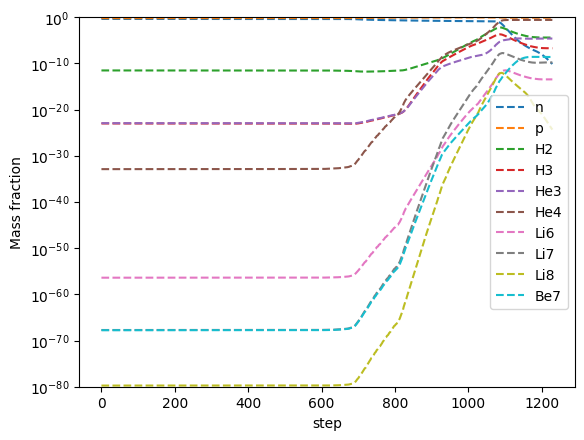

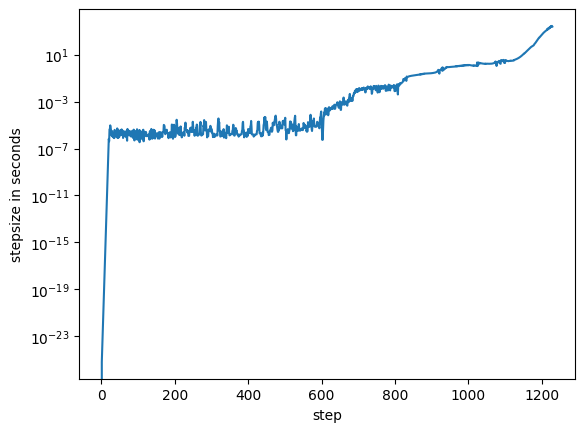

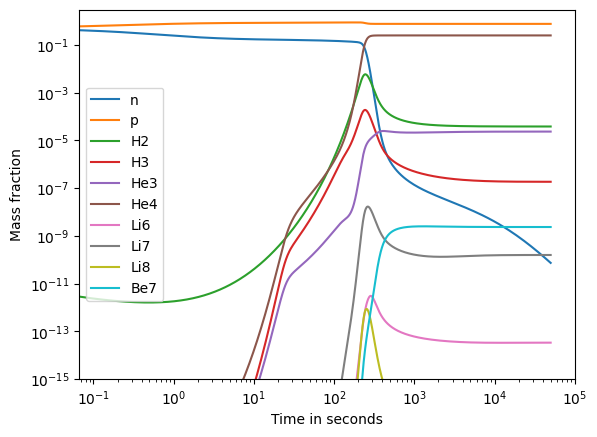

In [ ]:
# Plot the results 
jac_soltime=(jacsolY.t+t_ini)/timeunit   
plt.figure('abundance')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i in range(nNucs):
      plt.plot(range(len(jac_soltime)), A[i]*jacsolY.y[n_bparams+i],'--', color=colors[i], label=Y_labels[i])

plt.xlabel('step')
plt.ylabel('Mass fraction')
plt.ylim(1e-80,1)
#plt.xlim(0,20)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='right')
plt.show()
plt.figure('step size')
plt.plot(range(len(jac_soltime)),[(jacsolY.t[i]-jacsolY.t[i-1])/timeunit for i in range(len(jac_soltime))] )
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('stepsize in seconds')
'''
for i in range(nNucs):
    plt.plot(soltime, A[i]*nsolY.y[n_bparams+i],color=colors[i], label=Y_labels[i])
    plt.plot(jac_soltime, A[i]*jacsolY.y[n_bparams+i],'--', color=colors[i], label='jac_'+Y_labels[i])

plt.xlabel('time in seconds')
plt.ylabel('Mass fraction')
plt.ylim(1e-80,1e-30)
plt.xlim(t_ini/timeunit*0.9,0.4)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='right')
plt.show()
'''

plt.figure('abundance')
for i in range(nNucs):
    plt.plot(jac_soltime, A[i]*jacsolY.y[n_bparams+i], color=colors[i], label=Y_labels[i])

plt.xlabel('Time in seconds')
plt.ylabel('Mass fraction')
plt.ylim(1e-15,3)
plt.xlim(t_ini/timeunit,1e5)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()




In [ ]:
27/TMeV2T9